In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from art.attacks.evasion import BasicIterativeMethod
from art.estimators.classification import TensorFlowV2Classifier


In [11]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [12]:
# Take a subset of the dataset (e.g., first 1000 samples)
subset_size = 1000
x_train_subset, y_train_subset = x_train[:subset_size] / 255.0, y_train[:subset_size]
x_test_subset, y_test_subset = x_test[:subset_size] / 255.0, y_test[:subset_size]

In [13]:
# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 100
y_train_subset = to_categorical(y_train_subset, num_classes)
y_test_subset = to_categorical(y_test_subset, num_classes)


In [14]:
# Function to build the model
def build_model(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [15]:
# Build and compile model for CIFAR-100
model = build_model(num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train the model on CIFAR-100 subset
model.fit(x_train_subset, y_train_subset, epochs=10, batch_size=64, validation_data=(x_test_subset, y_test_subset))

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0076 - loss: 4.6156 - val_accuracy: 0.0230 - val_loss: 4.6012
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0208 - loss: 4.5798 - val_accuracy: 0.0180 - val_loss: 4.5901
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0222 - loss: 4.5174 - val_accuracy: 0.0230 - val_loss: 4.5441
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0393 - loss: 4.4434 - val_accuracy: 0.0280 - val_loss: 4.5297
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0531 - loss: 4.2864 - val_accuracy: 0.0350 - val_loss: 4.4468
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0665 - loss: 4.1317 - val_accuracy: 0.0450 - val_loss: 4.4252
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1121 - loss: 4.0289 - val_accuracy: 0.0620 - val_loss: 4.4085
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1246 - loss: 3.8958 - val_accuracy: 0.0590 - v

In [17]:
# Create ART classifier
classifier = TensorFlowV2Classifier(model=model, nb_classes=num_classes, input_shape=(32, 32, 3), loss_object=tf.keras.losses.CategoricalCrossentropy())

In [18]:
# BIM Attack
bim_attack = BasicIterativeMethod(estimator=classifier, eps=0.1, eps_step=0.01, max_iter=40)
x_test_bim = bim_attack.generate(x=x_test_subset)
loss, accuracy = model.evaluate(x_test_bim, y_test_subset, verbose=0)
print(f"CIFAR-100 BIM Attack Accuracy: {accuracy * 100:.2f}%")

CIFAR-100 BIM Attack Accuracy: 2.30%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08431373..1.1].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04509804..1.0019608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.060784314..1.0333333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0372549..1.0372549].


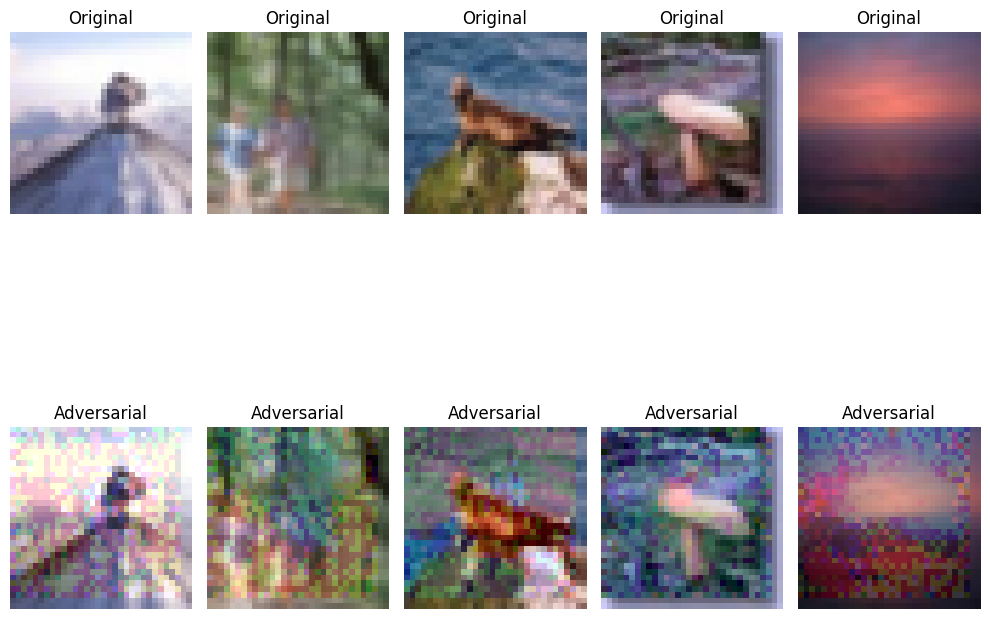

In [19]:
# Visualization function
def visualize_examples(x_test, x_adv, num_examples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis('off')
        plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(x_adv[i])
        plt.title("Adversarial")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize examples
visualize_examples(x_test_subset, x_test_bim)